C:\Users\bs23037\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\bs23037\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Deeper CNN...
Epoch 1/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 65s 25ms/step - accuracy: 0.8878 - loss: 0.3914 - val_accuracy: 0.9735 - val_loss: 0.1174
Epoch 2/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 63s 25ms/step - accuracy: 0.9668 - loss: 0.1323 - val_accuracy: 0.9759 - val_loss: 0.0932
Epoch 3/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.9750 - loss: 0.0943 - val_accuracy: 0.9794 - val_loss: 0.0725
Epoch 4/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 72s 29ms/step - accuracy: 0.9790 - loss: 0.0781 - val_accuracy: 0.9849 - val_loss: 0.0527
Epoch 5/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - accuracy: 0.9827 - loss: 0.0656 - val_accuracy: 0.9864 - val_loss: 0.0505
Epoch 6/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - accuracy: 0.9844 - loss: 0.0568 - val_accuracy: 0.9868 - val_loss: 0.0508
Epoch 7/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/step - accuracy: 0.9864 - loss: 0.0504 - val_accuracy: 0.9880 - val_loss: 0.0410
Epoch 8/50
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 73s 29ms/st

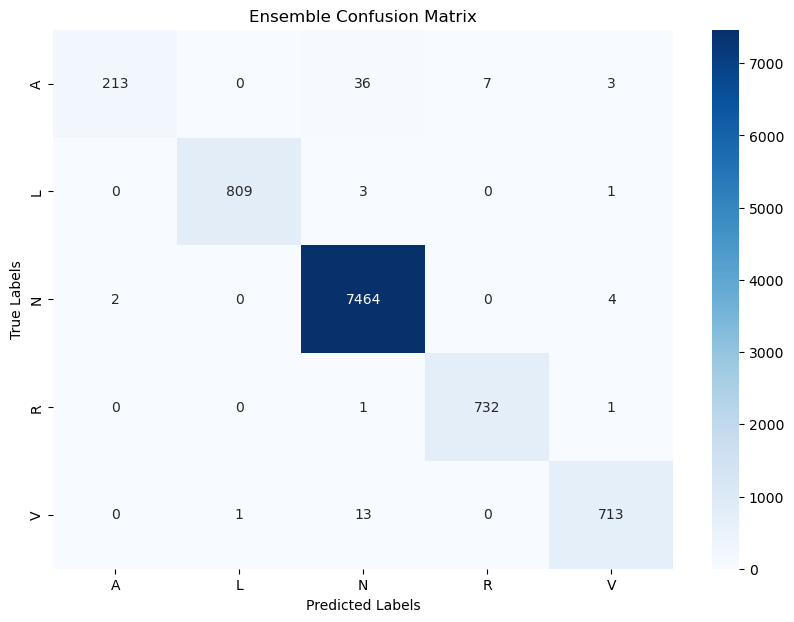

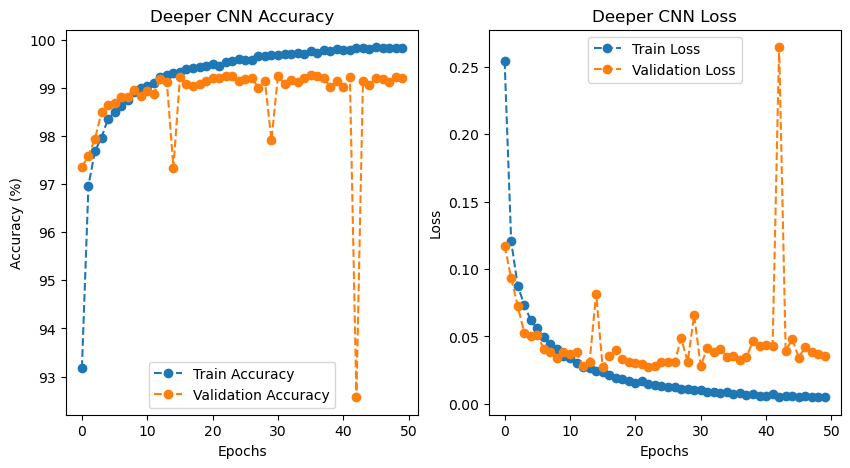

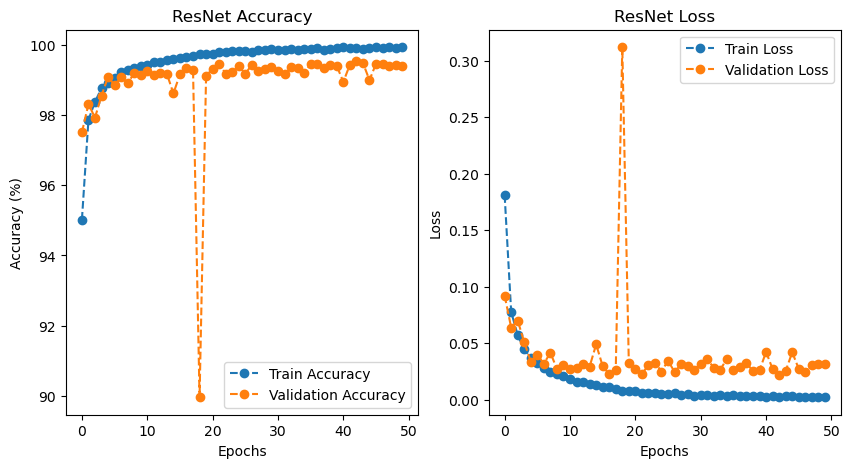

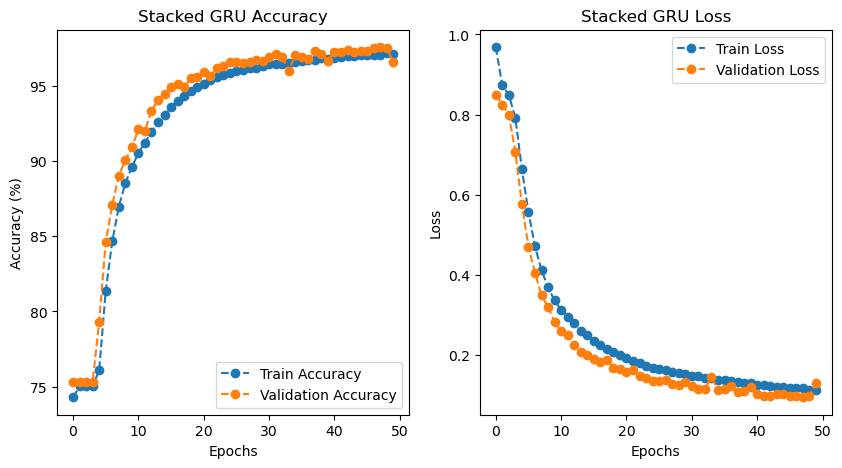

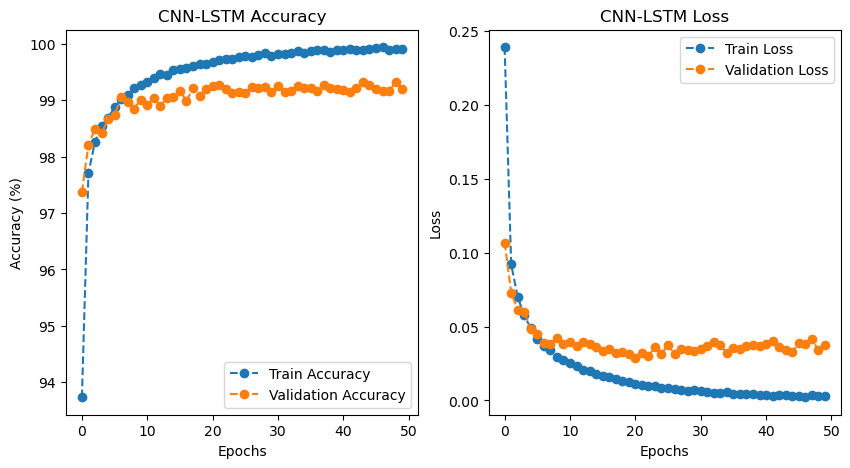

In [4]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GRU, Reshape, Add, Input, Flatten, LSTM, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define the path to the extracted dataset
data_path = 'M:\Dissertation\mit-bih-arrhythmia-database-1.0.0-20240722T094228Z-001\mit-bih-arrhythmia-database-1.0.0'

# Function to load a record and preprocess
def load_and_preprocess(record):
    signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
    annotation = wfdb.rdann(os.path.join(data_path, record), 'atr')
    
    # Use only one channel (e.g., channel 0)
    signal = signal[:, 0].reshape(-1, 1)
    
    # Segment the signal
    segments = []
    labels = []
    for i in range(len(annotation.sample)):
        if annotation.sample[i] - 99 > 0 and annotation.sample[i] + 160 < len(signal):
            segments.append(signal[annotation.sample[i] - 99 : annotation.sample[i] + 161])
            labels.append(annotation.symbol[i])
    
    return np.array(segments), np.array(labels)

# Function to load and preprocess all records in the dataset
def load_and_preprocess_all_records(data_path):
    all_segments = []
    all_labels = []
    
    for record in os.listdir(data_path):
        if record.endswith('.dat'):
            record_name = record[:-4]  # Remove the file extension
            segments, labels = load_and_preprocess(record_name)
            all_segments.append(segments)
            all_labels.append(labels)
    
    # Concatenate all segments and labels
    all_segments = np.vstack(all_segments)
    all_labels = np.concatenate(all_labels)
    
    return all_segments, all_labels

# Load and preprocess the entire dataset
segments, labels = load_and_preprocess_all_records(data_path)

# Filter out unwanted labels (keeping only certain labels, e.g., 'N', 'L', 'R', 'A', 'V')
valid_labels = ['N', 'L', 'R', 'A', 'V']
mask = np.isin(labels, valid_labels)
segments = segments[mask]
labels = labels[mask]

# Reshape segments to fit the model's expected input shape
segments = segments.reshape(segments.shape[0], segments.shape[1], 1, 1)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to categorical format
labels_categorical = tf.keras.utils.to_categorical(labels_encoded)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(segments, labels_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 1. Deeper CNN Model with Regularization and Batch Normalization
def create_deeper_cnn(input_shape, num_classes):
    model = Sequential([
        Conv2D(64, (5, 1), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 1)),
        Conv2D(128, (3, 1), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 1)),
        Conv2D(256, (3, 1), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 1)),
        Conv2D(512, (3, 1), activation='relu'),
        BatchNormalization(),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. ResNet-like Model with Regularization
def create_resnet(input_shape, num_classes):
    def residual_block(x, filters):
        shortcut = x
        x = Conv2D(filters, (3, 1), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, (3, 1), activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        
        # Adjust the shortcut to have the same number of filters as x
        shortcut = Conv2D(filters, (1, 1), activation='linear', padding='same')(shortcut)
        x = Add()([x, shortcut])
        return x

    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 1), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 1))(x)
    x = residual_block(x, 64)
    x = MaxPooling2D((2, 1))(x)
    x = residual_block(x, 128)
    x = MaxPooling2D((2, 1))(x)
    x = residual_block(x, 256)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 3. Stacked GRU Model with Regularization
def create_stacked_gru(input_shape, num_classes):
    model = Sequential([
        GRU(32, return_sequences=True, input_shape=input_shape),
        GRU(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 4. CNN-LSTM Model with Regularization
def create_cnn_lstm(input_shape_cnn, input_shape_lstm, num_classes):
    cnn_model = Sequential([
        Conv2D(32, (5, 1), activation='relu', input_shape=input_shape_cnn),
        MaxPooling2D((2, 1)),
        Conv2D(64, (3, 1), activation='relu'),
        Flatten(),
        Dense(260 * 32, activation='relu')  # Adjusted to match the LSTM input
    ])
    
    cnn_input = Input(shape=input_shape_cnn)
    cnn_output = cnn_model(cnn_input)
    
    # Correctly reshape the CNN output to match LSTM input expectations
    timesteps = input_shape_lstm[0]  # This is typically the length of the input sequence
    features = 32  # Reduced the features to match the Dense layer output
    
    lstm_input = Reshape((timesteps, features))(cnn_output)
    lstm_output = LSTM(32)(lstm_input)
    
    output = Dense(num_classes, activation='softmax')(lstm_output)
    
    model = Model(inputs=cnn_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the input shape based on your data
input_shape_lstm_gru = (segments.shape[1], 1)  # (timesteps, features) for LSTM/GRU
input_shape_cnn_resnet = (segments.shape[1], 1, 1)  # (timesteps, features, 1) for CNN/ResNet

# Number of classes
num_classes = len(valid_labels)

# Create the models
deeper_cnn_model = create_deeper_cnn(input_shape_cnn_resnet, num_classes)
resnet_model = create_resnet(input_shape_cnn_resnet, num_classes)
stacked_gru_model = create_stacked_gru(input_shape_lstm_gru, num_classes)
cnn_lstm_model = create_cnn_lstm(input_shape_cnn_resnet, input_shape_lstm_gru, num_classes)

# Train the models and store history
models = [
    (deeper_cnn_model, 'Deeper CNN', 50),
    (resnet_model, 'ResNet', 50),
    (stacked_gru_model, 'Stacked GRU', 50),
    (cnn_lstm_model, 'CNN-LSTM', 50)
]

histories = {}

for model, name, epochs in models:
    print(f'Training {name}...')
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=32)
    total_training_time = time.time() - start_time
    print(f"Total Training Time for {name}: {total_training_time:.2f} seconds")
    histories[name] = history

# Predict using all models
y_pred_deeper_cnn = deeper_cnn_model.predict(X_test)
y_pred_resnet = resnet_model.predict(X_test)
y_pred_stacked_gru = stacked_gru_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Ensemble method - Average predictions from all models
y_pred_ensemble = (y_pred_deeper_cnn + y_pred_resnet + y_pred_stacked_gru + 
                   y_pred_cnn_lstm) / 4
y_pred_classes_ensemble = np.argmax(y_pred_ensemble, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix_ensemble = confusion_matrix(y_test_classes, y_pred_classes_ensemble)

# Compute the metrics
overall_accuracy_ensemble = np.sum(y_pred_classes_ensemble == y_test_classes) / len(y_test_classes)
overall_sensitivity_ensemble = recall_score(y_test_classes, y_pred_classes_ensemble, average='macro') * 100
overall_specificity_ensemble = (conf_matrix_ensemble[0,0] / (conf_matrix_ensemble[0,0] + conf_matrix_ensemble[0,1])) * 100 if conf_matrix_ensemble.shape[0] > 1 else 0
overall_precision_ensemble = precision_score(y_test_classes, y_pred_classes_ensemble, average='macro') * 100
overall_fscore_ensemble = f1_score(y_test_classes, y_pred_classes_ensemble, average='macro') * 100

# Print the ensemble results
print(f"Results for Ensemble of All Models:")
print(f"Overall Accuracy: {overall_accuracy_ensemble * 100:.2f}%")
print(f"Overall Sensitivity: {overall_sensitivity_ensemble:.2f}%")
print(f"Overall Specificity: {overall_specificity_ensemble:.2f}%")
print(f"Overall Precision: {overall_precision_ensemble:.2f}%")
print(f"Overall F-Score: {overall_fscore_ensemble:.2f}%")

# Calculate per-class metrics
class_names = label_encoder.inverse_transform(np.arange(num_classes))
accuracy_per_class_ensemble = []
sensitivity_per_class_ensemble = []
specificity_per_class_ensemble = []
precision_per_class_ensemble = []
f1score_per_class_ensemble = []

for i, class_name in enumerate(class_names):
    true_positive = conf_matrix_ensemble[i, i]
    false_positive = np.sum(conf_matrix_ensemble[:, i]) - true_positive
    false_negative = np.sum(conf_matrix_ensemble[i, :]) - true_positive
    true_negative = np.sum(conf_matrix_ensemble) - (true_positive + false_positive + false_negative)
    
    accuracy = (true_positive + true_negative) / np.sum(conf_matrix_ensemble) * 100
    sensitivity = true_positive / (true_positive + false_negative) * 100 if (true_positive + false_negative) > 0 else 0
    specificity = true_negative / (true_negative + false_positive) * 100 if (true_negative + false_positive) > 0 else 0
    precision = true_positive / (true_positive + false_positive) * 100 if (true_positive + false_positive) > 0 else 0
    f1score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
    
    accuracy_per_class_ensemble.append(accuracy)
    sensitivity_per_class_ensemble.append(sensitivity)
    specificity_per_class_ensemble.append(specificity)
    precision_per_class_ensemble.append(precision)
    f1score_per_class_ensemble.append(f1score)

# Display the ensemble results in a DataFrame
performance_df_ensemble = pd.DataFrame({
    'Classes': class_names,
    'Accuracy (%)': accuracy_per_class_ensemble,
    'Sensitivity (%)': sensitivity_per_class_ensemble,
    'Specificity (%)': specificity_per_class_ensemble,
    'Precision (%)': precision_per_class_ensemble,
    'F1 Score (%)': f1score_per_class_ensemble
})

# Add overall accuracy to match the table
performance_df_ensemble['Overall Accuracy (%)'] = overall_accuracy_ensemble * 100

print(performance_df_ensemble)

# Plot ensemble confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Ensemble Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot accuracy and loss graphs for each model
for name, history in histories.items():
    plt.figure(figsize=(10, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(np.array(history.history['accuracy']) * 100, 'o--', label='Train Accuracy')
    plt.plot(np.array(history.history['val_accuracy']) * 100, 'o--', label='Validation Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'o--', label='Train Loss')
    plt.plot(history.history['val_loss'], 'o--', label='Validation Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
